## Modules à importer

In [2]:
import math
import scipy
import pickle
import sncosmo
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa import tools as vtools
from variaIa import baserate
from importlib import reload
from variaIa import stretchevol
from variaIa import massevol
from scipy.stats import poisson
from snprop import survey, tools
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cdata
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full, z_max
from scipy.ndimage.filters import uniform_filter1d
from IPython.display import display, Latex
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True})
plt.rcParams['figure.facecolor'] = 'w'
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

### Définition des données à montrer

In [3]:
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=vtools.cons, su=vtools.su)
display(ipw.HBox([int_set_su, btw, after]))

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'LOWZ': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)}

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
surveysnl = surveys[0:1]+surveys[2:]

## Définitions des dictionnaires

In [4]:
##############################################################################
############## $z[:z_max]$, $x_1[:z_max]$, data_all, mean et std #############
##############################################################################

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()
c_zcuts = dict()
c_err_zcuts = dict()

for survey in surveys:
    zmax_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][1])
    z_zcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zmax_cuts[survey]]
    x1_zcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zmax_cuts[survey]]
    c_zcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zmax_cuts[survey]]
    c_err_zcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zmax_cuts[survey]]

datax_all = (np.concatenate(
    (np.concatenate(
        (x1_zcuts['SDSS'],
         x1_zcuts['PS1'])),
     x1_zcuts['SNLS'])))
                                                     
datax_err_all = (np.concatenate(
    (np.concatenate(
        (x1_err_zcuts['SDSS'],
         x1_err_zcuts['PS1'])),
     x1_err_zcuts['SNLS'])))
                                                     
dataz_all = (np.concatenate(
    (np.concatenate(
        (z_zcuts['SDSS'],
         z_zcuts['PS1'])),
     z_zcuts['SNLS'])))

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()
c_mean = dict()
c_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])
    c_mean[survey] = np.mean(c_zcuts[survey])
    c_std[survey] = np.std(c_zcuts[survey])
    
##############################################################################
##################### $[:z_inf]$, $[z_sup:]$ et mean_inf #####################
##############################################################################

zinf_cuts = dict()
z_zinfcuts = dict()
x1_zinfcuts = dict()
x1_err_zinfcuts = dict()
c_zinfcuts = dict()
c_err_zinfcuts = dict()

for survey in surveys:
    zinf_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][0])
    z_zinfcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zinf_cuts[survey]]
    x1_zinfcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zinf_cuts[survey]]
    x1_err_zinfcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zinf_cuts[survey]]
    c_zinfcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zinf_cuts[survey]]
    c_err_zinfcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zinf_cuts[survey]]

z_inf_mean = dict()
z_inf_std = dict()
x1_inf_mean = dict()
x1_inf_std = dict()
c_inf_mean = dict()
c_inf_std = dict()

for survey in surveys:
    z_inf_mean[survey] = np.mean(z_zinfcuts[survey])
    z_inf_std[survey] = np.std(z_zinfcuts[survey])
    x1_inf_mean[survey] = np.mean(x1_zinfcuts[survey])
    x1_inf_std[survey] = np.std(x1_zinfcuts[survey])
    c_inf_mean[survey] = np.mean(c_zinfcuts[survey])
    c_inf_std[survey] = np.std(c_zinfcuts[survey])

zsup_cuts = dict()
z_zsupcuts = dict()
x1_zsupcuts = dict()
x1_err_zsupcuts = dict()
c_zsupcuts = dict()
c_err_zsupcuts = dict()

for survey in surveys:
    zsup_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values > z_max[survey][1])
    z_zsupcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zsup_cuts[survey]]
    x1_zsupcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zsup_cuts[survey]]
    x1_err_zsupcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zsup_cuts[survey]]
    c_zsupcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zsup_cuts[survey]]
    c_err_zsupcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zsup_cuts[survey]]
   
names_sup = []
stretchs_sup = []
stretchs_err_sup = []
colors_sup = []
colors_err_sup = []
redshifts_sup = []

for survey in surveys[1:-1]:
    names_sup += [survey for i in range(len(z_zsupcuts[survey]))] 
    stretchs_sup += list(x1_zsupcuts[survey]) 
    stretchs_err_sup += list(x1_err_zsupcuts[survey]) 
    colors_sup += list(c_zsupcuts[survey]) 
    colors_err_sup += list(c_err_zsupcuts[survey]) 
    redshifts_sup += list(z_zsupcuts[survey]) 

df_sup = pd.DataFrame({'survey': names_sup,
                        'stretchs': stretchs_sup,
                        'stretchs_err': stretchs_err_sup,
                        'colors': colors_sup,
                        'colors_err': colors_err_sup,
                        'redshifts': redshifts_sup})

##############################################################################
########################## $[z_max, inf:z_max, sup]$ #########################
##############################################################################

zbtw_cuts = dict()
z_zbtwcuts = dict()
x1_zbtwcuts = dict()
x1_err_zbtwcuts = dict()
c_zbtwcuts = dict()
c_err_zbtwcuts = dict()

for survey in surveys:
    zbtw_cuts[survey] = np.where((df_full[df_full['survey'] == survey].redshifts.values > z_max[survey][0])
                               & (df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][1]))
    z_zbtwcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zbtw_cuts[survey]]
    x1_zbtwcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zbtw_cuts[survey]]
    x1_err_zbtwcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zbtw_cuts[survey]]
    c_zbtwcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zbtw_cuts[survey]]
    c_err_zbtwcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zbtw_cuts[survey]]

### Plot base model shape

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/stretchevol.py:203: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)


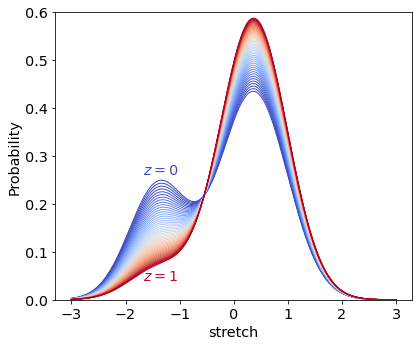

In [46]:
gen = stretchevol.generic()
gen.set_model('Evol3G2M2S')
baseTOT = gen.fit(df_nc)

fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
plt.rcParams.update({"text.usetex": False})

dgmap = plt.cm.get_cmap('coolwarm')

x_lin = np.linspace(-3, 3, 1000)
z_lin = np.linspace(0, 1, 50)

z_m, z_p = np.percentile(z_lin, [5, 95])

for z in z_lin:
    pdfmodel_mid = baseTOT.likelihood_tot(baseTOT.delta(z),
                                          x_lin, 0, #np.mean(dx1),
                                          baseTOT.param['aa'],
                                          baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                          baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
    ax.plot(x_lin,
            pdfmodel_mid,
            color=dgmap((z-z_m)/(z_p-z_m)),
            lw=1)
    
ax.text(-1.35, 0.27, r'$z=0$', color=dgmap(0),
        fontsize='x-large', ha='center', va='center')

ax.text(-1.35, 0.05, r'$z=1$', color=dgmap(0.99),
        fontsize='x-large', ha='center', va='center')

ax.set_ylim(0, 0.6)

ax.set_xlabel('stretch', fontsize='x-large')
ax.set_ylabel('Probability', fontsize='x-large')
ax.tick_params(labelsize='x-large')

fig.savefig('../../../Images/pdf/model_base_pdf-0-1.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/model_base_pdf-0-1.png', bbox_inches='tight', dpi=600)

In [14]:
# gen = stretchevol.generic()
# gen.set_model('Evol3G2M2S')
# baseTOT = gen.fit(df_nc)
baseTOT = stretchevol.Evol3G2M2S(df_nc)
baseTOT.minimize()
x_lin = np.linspace(-3, 3, 1000)
pdfmodel_mid = baseTOT.likelihood_tot(baseTOT.delta(0.15),
                                      x_lin, 0, #np.mean(dx1),
                                      baseTOT.param['aa'],
                                      baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                      baseTOT.param['mu_2'], baseTOT.param['sigma_2'])

In [5]:
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/basemodel-lin.txt', x_lin)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/basemodel-val.txt', pdfmodel_mid)

### Plot asymgaus color shape (PS1)

In [12]:
gen.set_model('Evol1G1M2S')
asym = gen.fit(df_nc)
c_lin = np.linspace(-0.3, 0.3, 1000)
casym = asym.likelihood_tot(c_lin, np.array([0. for i in range(len(c_lin))]),
                            -0.068, 0.034, 0.123)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/casym-lin.txt', c_lin)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/casym-val.txt', casym)

### Plot mass distribution of hostlib

In [8]:
samples = ['lowz', 'found', 'highz']

sm = ipw.Dropdown(options=samples,
                  description='Sample:',
                  value='lowz')

display(sm)

Dropdown(description='Sample:', options=('lowz', 'found', 'highz'), value='lowz')

In [9]:
hostlib = pd.read_csv('/home/nicolas/Work/devpython/variaIa/Data/hostlibs/'+
                      f'BP_{sm.value}.HOSTLIB', skiprows=[0], delim_whitespace=True)

In [10]:
ran_mass = hostlib['LOGMASS']#.sample(100000)

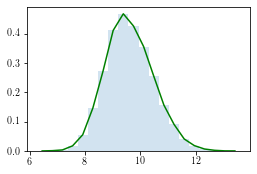

In [12]:
fig = plt.figure(figsize=[5, 2.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

histout = ax.hist(ran_mass, bins=20, density=True, alpha=0.2)
ax.plot((histout[1][:-1]+histout[1][1:])/2, histout[0], color='green')

In [18]:
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/mdist-lin.txt', (histout[1][:-1]+histout[1][1:])/2)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/mdist-val.txt', histout[0])

### $\texttt{SALT2.4}$ time series and point band PS1

Text(0, 0.5, 'Phase relative to $t_0$ (days)')

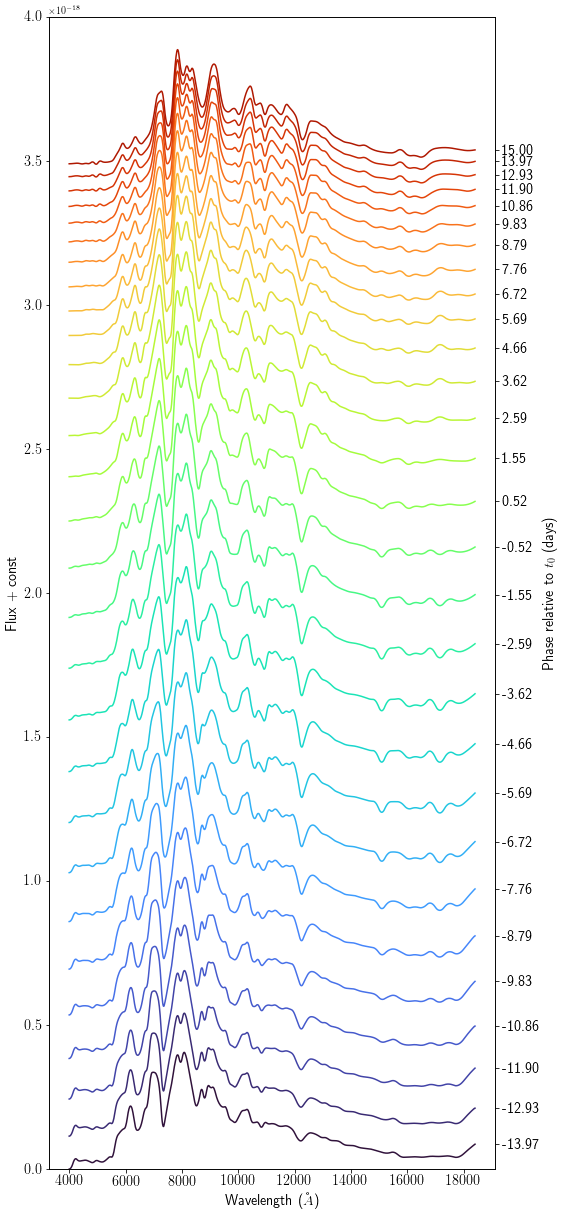

In [16]:
model = sncosmo.Model('salt2')
model.set(c=0.05, x1=0.5, z=1.0, t0=55100.)
model.set_source_peakabsmag(-19.36, 'sdssr', 'ab', cosmo=cdata)

t_lin = np.linspace(55100-15, 55100+15, 30)
w_lin = np.linspace(model.minwave(), model.maxwave(), 1000)
fluxes = {t_lin[i]: model.flux(time=t_lin[i], wave=w_lin)
          for i in range(len(t_lin))}
const=2.5e-19

fig = plt.figure(figsize=[10, 20])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
axd = ax.twinx()

cmap = plt.cm.get_cmap('turbo')
end_coords = []
end_labels = t_lin[1:]-55100
end_labels = list(map('{:.2f}'.format,end_labels))
for i,t in enumerate(t_lin[1:]):
    ax.plot(w_lin,
            fluxes[t]+0.3*i*np.max(fluxes[t_lin[i-1]]),
            color=cmap(i/len(t_lin)))
    end_coords.append(fluxes[t][-1]+0.3*i*np.max(fluxes[t_lin[i-1]]))

ax.tick_params(labelsize='x-large')
axd.set_yticks(end_coords)
#axd.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
axd.set_yticklabels(end_labels)
axd.tick_params(labelsize='x-large')

ax.set_ylim(0,4e-18)
axd.set_ylim(ax.get_ylim())

ax.set_xlabel(r'Wavelength ($\AA$)', fontsize='x-large')
ax.set_ylabel('Flux + const', fontsize='x-large')
axd.set_ylabel(r'Phase relative to $t_0$ (days)', fontsize='x-large')

#fig.savefig('/home//nicolas/Work/Articles/2022-PhD/Figures/timeseries.pdf', bbox_inches='tight')
#fig.savefig('../../../Images/pdf/timeseries.pdf', bbox_inches='tight')

Text(0, 0.5, 'Transmission')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
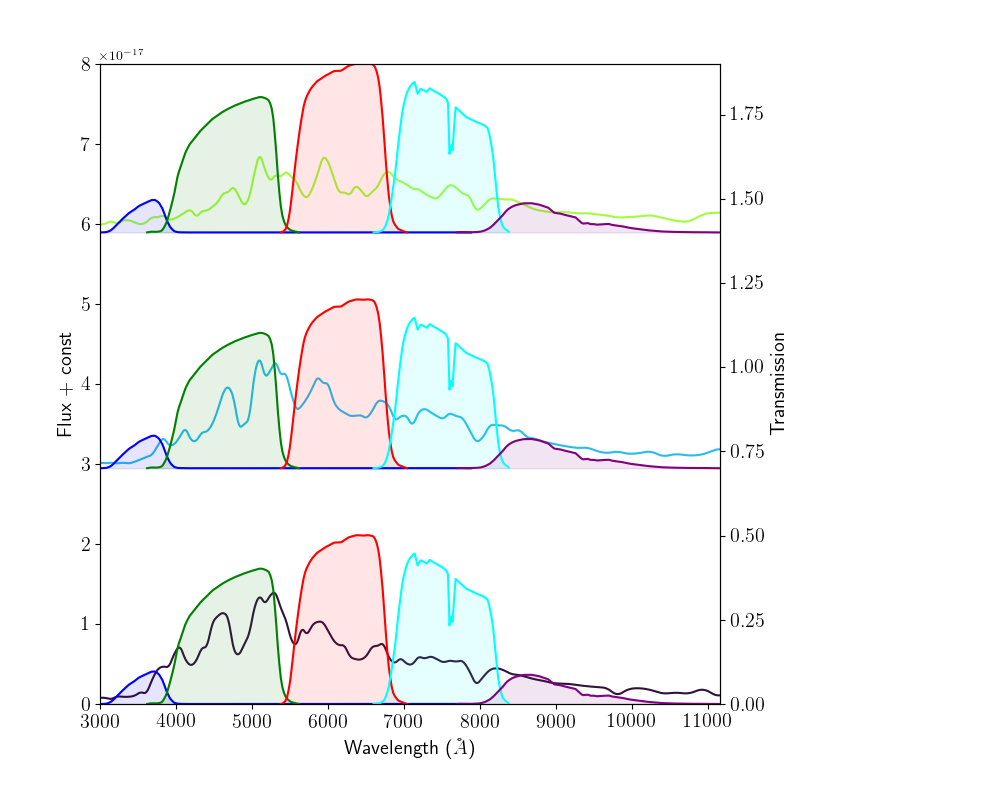

In [44]:
%matplotlib widget
model = sncosmo.Model('salt2')
model.set(c=0.05, x1=0.5, z=0.3, t0=55100.)
model.set_source_peakabsmag(-19.36, 'sdssr', 'ab', cosmo=cdata)

t_lin = np.linspace(55100-15, 55100+15, 4)
w_lin = np.linspace(model.minwave(), model.maxwave(), 1000)
fluxes = {t_lin[i]: model.flux(time=t_lin[i], wave=w_lin)
          for i in range(len(t_lin))}
const=2.5e-19

fig = plt.figure(figsize=[10, 8])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
axd = ax.twinx()

cmap = plt.cm.get_cmap('turbo')

for i,t in enumerate(t_lin[1:]):
    ax.plot(w_lin,
            fluxes[t]+i*3e-17,
            color=cmap(i/len(t_lin)))
    for f,c in zip(['u', 'g', 'r', 'i', 'z'],
                   ['b', 'g', 'r', 'cyan', 'purple']):
        b = sncosmo.get_bandpass(f'sdss{f}')
        shift = 0.70
        axd.plot(b.wave, b.trans+i*shift,
                label=f'sdss{f}', color=c)
        axd.fill_between(b.wave, b.trans+i*shift,
                         [i*shift for j in range(len(b.trans))],
                         color=c, alpha=.1)

ax.tick_params(labelsize='x-large')
axd.tick_params(labelsize='x-large')

ax.set_xlim(3000, np.max(b.wave))
ax.set_ylim(0,80e-18)
axd.set_ylim(0,1.9)

ax.set_xlabel(r'Wavelength ($\AA$)', fontsize='x-large')
ax.set_ylabel('Flux + const', fontsize='x-large')

axd.set_ylabel('Transmission', fontsize='x-large')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
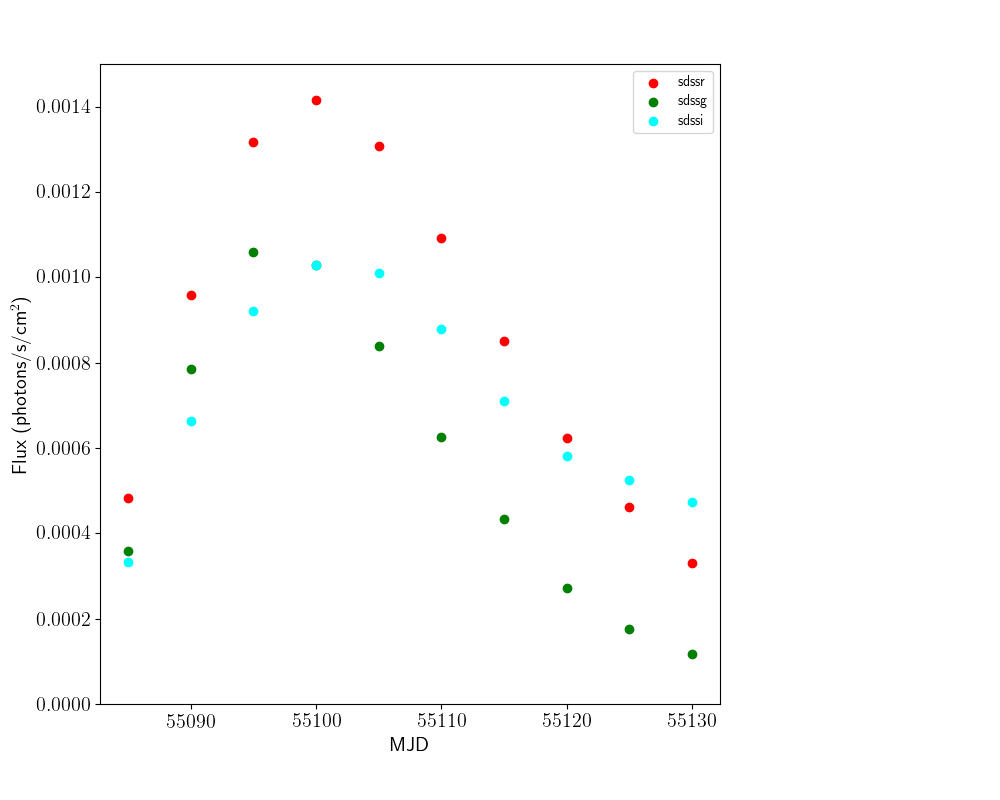

In [65]:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

t_lin = np.linspace(55100-15, 55100+30, 10)

for band,c in zip(['sdssr', 'sdssg', 'sdssi'],
                  ['r', 'g', 'cyan']):
    ax.scatter(t_lin, model.bandflux(band, t_lin),
           c=c, label=band)

ax.tick_params(labelsize='x-large')
ax.set_ylim(0,0.0015)

ax.set_xlabel(r'MJD', fontsize='x-large')
ax.set_ylabel(r'Flux (photons/s/cm$^2$)', fontsize='x-large')

ax.legend()

### Plot curves before, after selection

In [5]:
lsurv = ['LOWZ', 'PS1', 'SDSS', 'SNLS']
dumptot = pd.read_csv('../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/DUMP/LOWZ_DATA.DUMP',
                      skiprows=5, delim_whitespace=True).drop('VARNAMES:', axis=1)
for s in lsurv[1:]:
    temp = pd.read_csv(f'../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/DUMP/{s}_DATA.DUMP',
                       skiprows=5, delim_whitespace=True).drop('VARNAMES:', axis=1)
    dumptot = dumptot.append(temp, ignore_index=True)

dumpass = dumptot[dumptot['SIM_SEARCHEFF_MASK']>0]
#dumptot

In [42]:
dumptot.columns

Index(['CID', 'SIM_SEARCHEFF_MASK', 'GENTYPE', 'SNTYPE', 'LOGMASS_TRUE',
       'GENZ', 'LIBID', 'RA', 'DECL', 'MWEBV', 'MWEBVMAP', 'MU', 'MJD0',
       'MAGT0_g', 'MAGT0_r', 'MAGT0_i', 'MAGT0_z', 'SNRMAX_g', 'SNRMAX_r',
       'SNRMAX_i', 'SNRMAX_z', 'SNRMAX', 'SNRMAX2', 'SNRMAX3', 'NOBS',
       'TRESTMIN', 'TRESTMAX', 'TGAPMAX', 'S2alpha', 'S2beta', 'S2x0', 'S2x1',
       'S2c'],
      dtype='object')

In [6]:
lsurv = ['LOWZ', 'PS1', 'SDSS', 'SNLS']
dumpsurv = dict()
dumpsass = dict()
for s in lsurv:
    dumpsurv[s] = pd.read_csv(f'../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/DUMP/{s}_DATA.DUMP',
                                skiprows=5, delim_whitespace=True).drop('VARNAMES:', axis=1)
    dumpsass[s] = dumpsurv[s][dumpsurv[s]['SIM_SEARCHEFF_MASK']>0]

### Curves after fit

In [7]:
fitall = tools.Checker.read('../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/LCFIT/LOWZ_DATA/FITOPT000.FITRES')
for s in lsurv[1:]:
    fitall = fitall.append(tools.Checker.read(
        f'../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/LCFIT/{s}_DATA/FITOPT000.FITRES'))

#fitall

In [34]:
fitall.columns

Index(['CID', 'IDSURVEY', 'TYPE', 'FIELD', 'CUTFLAG_SNANA', 'ERRFLAG_FIT',
       'zHEL', 'zHELERR', 'zCMB', 'zCMBERR', 'zHD', 'zHDERR', 'VPEC',
       'VPECERR', 'MWEBV', 'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'HOST_sSFR',
       'HOST_sSFR_ERR', 'PKMJDINI', 'SNRMAX1', 'SNRMAX2', 'SNRMAX3', 'PKMJD',
       'PKMJDERR', 'x1', 'x1ERR', 'c', 'cERR', 'mB', 'mBERR', 'x0', 'x0ERR',
       'COV_x1_c', 'COV_x1_x0', 'COV_c_x0', 'NDOF', 'FITCHI2', 'FITPROB',
       'SIM_TYPE_INDEX', 'SIM_TEMPLATE_INDEX', 'SIM_LIBID', 'SIM_NGEN_LIBID',
       'SIM_ZCMB', 'SIM_ZFLAG', 'SIM_VPEC', 'SIM_DLMAG', 'SIM_PKMJD', 'SIM_x1',
       'SIM_c', 'SIM_alpha', 'SIM_beta', 'SIM_gammaDM', 'SIM_x0', 'SIM_mB',
       'SIM_AV', 'SIM_RV'],
      dtype='object')

In [8]:
fitsurv = dict()
for s in lsurv:
    fitsurv[s] = tools.Checker.read(f'../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/LCFIT/{s}_DATA/FITOPT000.FITRES')

### Mass

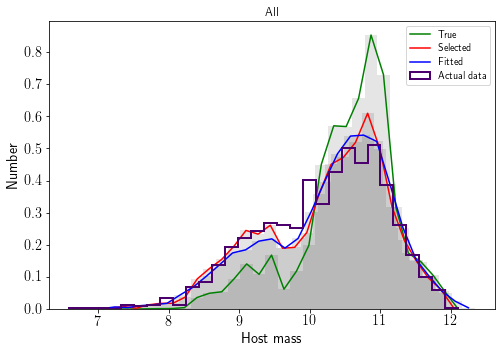

In [29]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
plt.rcParams['figure.facecolor'] = 'w'

histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}

toplot_all = {'surv': {},
              'sass': {},
              'fit': {}}
histout_all = {'LOWZ': {},
               'PS1': {},
               'SDSS': {},
               'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumptot, dumpass, fitall]
keyy = ['LOGMASS_TRUE', 'LOGMASS_TRUE', 'HOST_LOGMASS']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for tipe, df, key, c, label in zip(tipee, dff, keyy, cc, labell):
    toplot_all[tipe] = df[df[key] > 6][key]
    histout_all[tipe] = ax.hist(toplot_all[tipe], **histprop)
    ax.plot((histout_all[tipe][1][:-1]+histout_all[tipe][1][1:])/2,
            histout_all[tipe][0], color=c, label=label)

ax.hist(df_full[df_full['hostmass']>6]['hostmass'],
        bins=30, density=True, lw=2,
        histtype='step', color='xkcd:royal purple', label='Actual data')

ax.tick_params(labelsize='x-large')
ax.set_ylim(bottom=0)

ax.set_xlabel(r'Host mass', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend() 

ax.set_title('All')

fig.savefig(f'../../../Images/pdf/snana-hist_mass-all.pdf', bbox_inches='tight')

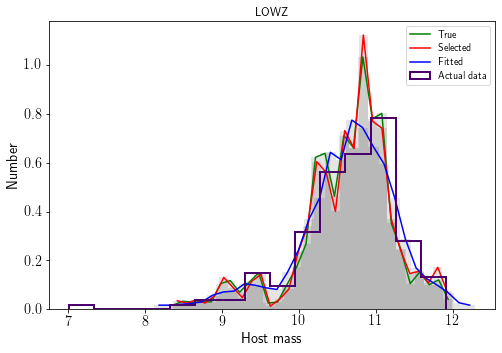

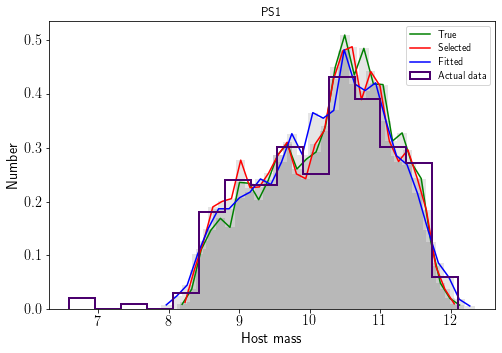

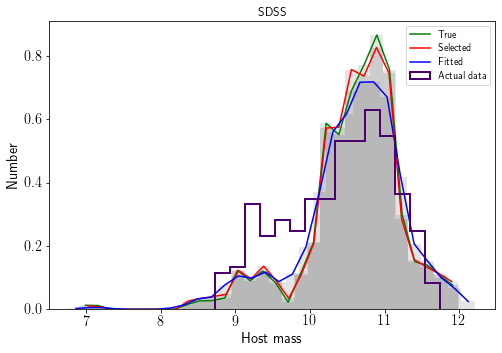

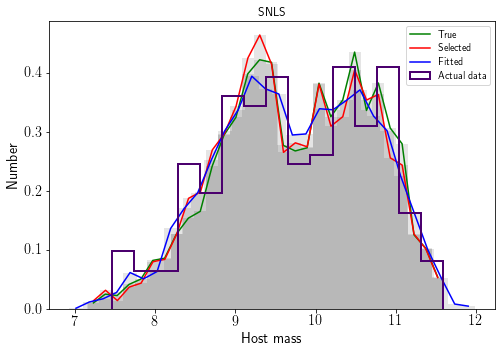

In [28]:
histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}

toplot = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}
histout = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumpsurv, dumpsass, fitsurv]
keyy = ['LOGMASS_TRUE', 'LOGMASS_TRUE', 'HOST_LOGMASS']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for s in lsurv:
    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    for tipe, df, key, c, l in zip(tipee, dff, keyy, cc, labell):
        toplot[s][tipe] = df[s][df[s][key] > 6][key]
        histout[s][tipe] = ax.hist(toplot[s][tipe], **histprop)
        ax.plot((histout[s][tipe][1][:-1]+histout[s][tipe][1][1:])/2,
                histout[s][tipe][0], color=c, label=l)
    ax.hist(df_full[df_full['survey']==s][
                    df_full[df_full['survey']==s]['hostmass']>6]['hostmass'],
            bins=15, density=True, lw=2,
            histtype='step', color='xkcd:royal purple',
            label='Actual data')
    ax.tick_params(labelsize='x-large')
    
    ax.set_xlabel(r'Host mass', fontsize='x-large')
    ax.set_ylabel(r'Number', fontsize='x-large')
    
    ax.legend() 
    
    ax.set_title(s)
    fig.savefig(f'../../../Images/pdf/snana-hist_mass-{s}.pdf', bbox_inches='tight')

### Stretch

Text(0.5, 1.0, 'All')

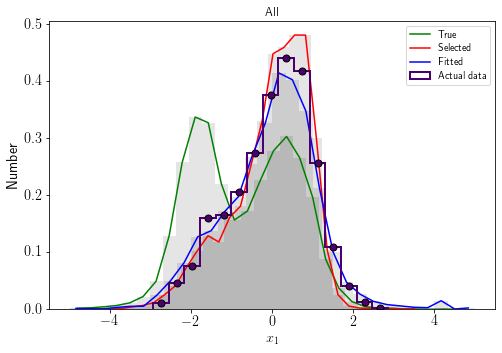

In [10]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}
prop = dict(marker="o", ms=7,
            ecolor="xkcd:royal purple", mew=1,
            mec="k", mfc="xkcd:royal purple", ls='none')

toplot_all = {'surv': {},
              'sass': {},
              'fit': {}}
histout_all = {'LOWZ': {},
               'PS1': {},
               'SDSS': {},
               'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumptot, dumpass, fitall]
keyy = ['S2x1', 'S2x1', 'x1']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for tipe, df, key, c, label in zip(tipee, dff, keyy, cc, labell):
    toplot_all[tipe] = df[df[key] > -6][key]
    histout_all[tipe] = ax.hist(toplot_all[tipe], **histprop)
    ax.plot((histout_all[tipe][1][:-1]+histout_all[tipe][1][1:])/2,
            histout_all[tipe][0], color=c, label=label)

hist_df = ax.hist(df_full[df_full['stretchs']>-6]['stretchs'],
                  bins=15, density=True, lw=2,
                  histtype='step', color='xkcd:royal purple', label='Actual data')

ax.errorbar((hist_df[1][:-1]+hist_df[1][1:])/2,
            hist_df[0],# yerr=np.sqrt(hist_df[s][0]),
            **prop)

ax.tick_params(labelsize='x-large')
ax.set_ylim(bottom=0)

ax.set_xlabel(r'$x_1$', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend() 

ax.set_title('All')

#fig.savefig(f'../../../Images/pdf/snana-hist_stretch-all.pdf', bbox_inches='tight')

### Plot models on top of green

In [16]:
baseTOT = stretchevol.Evol3G2M2S(df_nc)
baseTOT.minimize()
x_lin = np.linspace(-3, 3, 1000)

pdfmodels = {}
pdfmmodel = {}

for s in lsurv:
    pdfmodels[s] = baseTOT.likelihood_tot(baseTOT.delta(
                                               np.mean(dumpsurv['LOWZ']['GENZ'])),
                                           x_lin, 0, #np.mean(dx1),
                                           baseTOT.param['aa'],
                                           baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                           baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
    #pdfmmodel[s] = np.mean(pdfmodels[s], axis=0)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/stretchevol.py:203: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  self.migrad_out = self.m_tot.migrad()


In [14]:
np.mean(dumpsurv['LOWZ']['GENZ'])

0.07418240317072018

In [15]:
baseTOT = stretchevol.Evol3G2M2S(df_nc)
baseTOT.minimize()
x_lin = np.linspace(-3, 3, 1000)

pdfmodel = baseTOT.likelihood_tot(baseTOT.delta(np.mean(dumpsurv['LOWZ']['GENZ'])),
                                           x_lin, 0, #np.mean(dx1),
                                           baseTOT.param['aa'],
                                           baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                           baseTOT.param['mu_2'], baseTOT.param['sigma_2'])

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/stretchevol.py:203: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  self.migrad_out = self.m_tot.migrad()


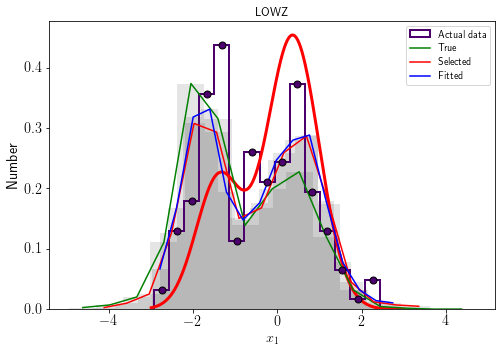

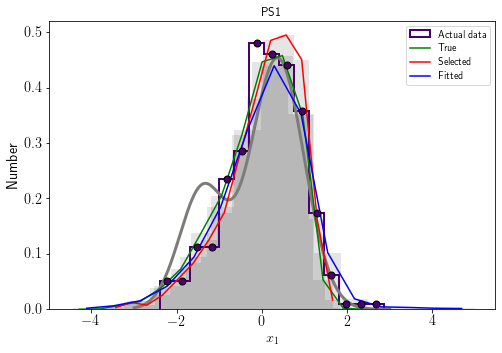

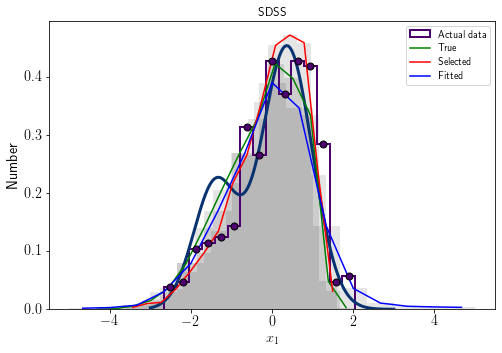

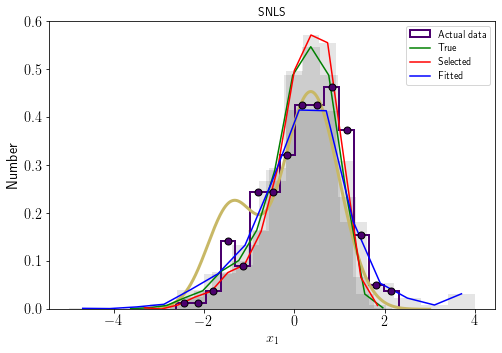

In [20]:
plt.rcParams['figure.facecolor'] = 'w'
histprop = {'bins':15, 'density':True, 'color':'k', 'alpha':.1}
prop = dict(marker="o", ms=7,
            ecolor="xkcd:royal purple", mew=1,
            mec="k", mfc="xkcd:royal purple", ls='none')

toplot = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}
histout = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}
df_plot = {}
hist_df = {}

tipee = ['surv', 'sass', 'fit']
dff = [dumpsurv, dumpsass, fitsurv]
keyy = ['S2x1', 'S2x1', 'x1']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for s in lsurv:
    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    
    df_plot[s] = df_full[df_full['survey']==s][\
                         df_full[df_full['survey']==s]['stretchs']>-6]['stretchs']
    hist_df[s] = ax.hist(df_plot[s],
                         bins=15, lw=2, density=True,
                         histtype='step', color='xkcd:royal purple',
                         label='Actual data')
    
    ax.plot(x_lin, pdfmodels[s], color=colors[s], lw=3)
    
    ax.errorbar((hist_df[s][1][:-1]+hist_df[s][1][1:])/2,
                 hist_df[s][0],# yerr=np.sqrt(hist_df[s][0]),
                **prop)
    
    for tipe, df, key, c, l in zip(tipee, dff, keyy, cc, labell):
        toplot[s][tipe] = df[s][df[s][key] > -6][key]
        histout[s][tipe] = ax.hist(toplot[s][tipe],
                                   #weights=[np.max(df_plot[s])
                                   #         for k in range(len(toplot[s][tipe]))],
                                   **histprop)
        ax.plot((histout[s][tipe][1][:-1]+histout[s][tipe][1][1:])/2,
                histout[s][tipe][0],#*len(df_plot[s]),
                color=c, label=l)

    ax.tick_params(labelsize='x-large')
    
    ax.set_xlabel(r'$x_1$', fontsize='x-large')
    ax.set_ylabel(r'Number', fontsize='x-large')

    ax.legend()
    
    ax.set_title(s)
    #plt.close()
    #fig.savefig(f'../../../Images/pdf/snana-hist_stretch-{s}.pdf', bbox_inches='tight')

In [46]:
x1_ks = {}

for s in lsurv:
    x1_ks[s] = scipy.stats.ks_2samp(toplot[s]['fit'], df_plot[s])[1]

In [47]:
x1_ks

{'LOWZ': 0.06920318724895858,
 'PS1': 0.6670183188591328,
 'SDSS': 0.031595438935562936,
 'SNLS': 0.2893316995194396}

### Color

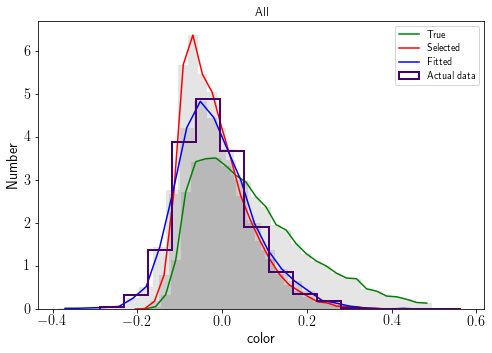

In [33]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}

toplot_all = {'surv': {},
              'sass': {},
              'fit': {}}
histout_all = {'LOWZ': {},
               'PS1': {},
               'SDSS': {},
               'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumptot, dumpass, fitall]
keyy = ['S2c', 'S2c', 'c']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for tipe, df, key, c, label in zip(tipee, dff, keyy, cc, labell):
    toplot_all[tipe] = df[(df[key] > -0.4) &
                          (df[key] < 0.6)][key]
    histout_all[tipe] = ax.hist(toplot_all[tipe], **histprop)
    ax.plot((histout_all[tipe][1][:-1]+histout_all[tipe][1][1:])/2,
            histout_all[tipe][0], color=c, label=label)
    
ax.hist(df_full[(df_full['colors']>-0.4) &
                (df_full['colors']<0.6)]['colors'],
        bins=15, density=True, lw=2,
        histtype='step', color='xkcd:royal purple', label='Actual data')
    
ax.tick_params(labelsize='x-large')
ax.set_ylim(bottom=0)

ax.set_xlabel(r'color', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend() 

ax.set_title('All')

fig.savefig(f'../../../Images/pdf/snana-hist_color-all.pdf', bbox_inches='tight')

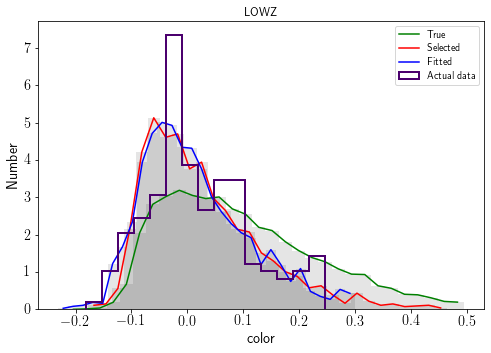

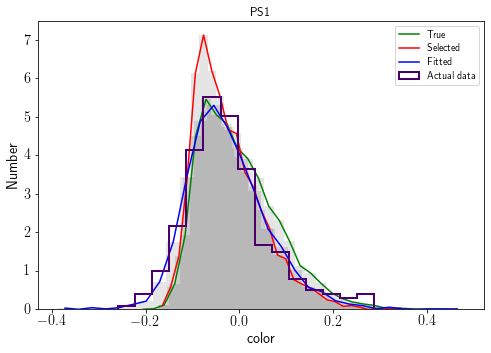

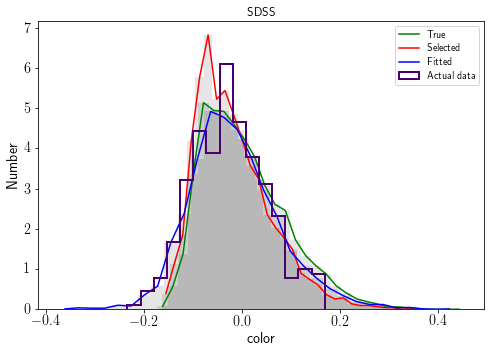

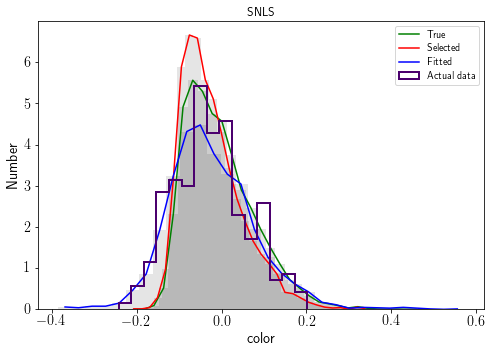

In [36]:
histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}

toplot = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}
histout = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumpsurv, dumpsass, fitsurv]
keyy = ['S2c', 'S2c', 'c']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for s in lsurv:
    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    for tipe, df, key, c, l in zip(tipee, dff, keyy, cc, labell):
        toplot[s][tipe] = df[s][(df[s][key] > -0.4) &
                               (df[s][key] < 0.6)][key]
        histout[s][tipe] = ax.hist(toplot[s][tipe], **histprop)
        ax.plot((histout[s][tipe][1][:-1]+histout[s][tipe][1][1:])/2,
                histout[s][tipe][0], color=c, label=l)
        
    ax.hist(df_full[df_full['survey']==s][
            df_full[df_full['survey']==s]['colors']>-0.4]['colors'],
    bins=15, density=True, lw=2,
    histtype='step', color='xkcd:royal purple',
    label='Actual data')
    
    ax.tick_params(labelsize='x-large')
        
    ax.set_xlabel(r'color', fontsize='x-large')
    ax.set_ylabel(r'Number', fontsize='x-large')
        
    ax.legend() 
        
    ax.set_title(s)
    
    fig.savefig(f'../../../Images/pdf/snana-hist_color-{s}.pdf', bbox_inches='tight')

### Redshift

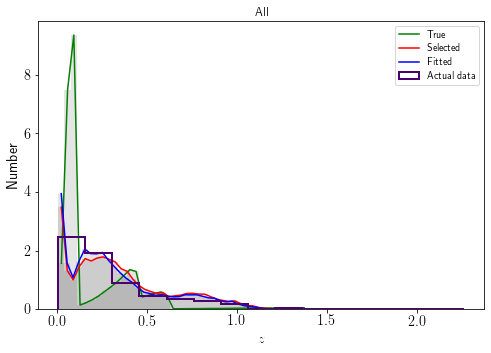

In [38]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

histprop = {'bins':40, 'density':True, 'color':'k', 'alpha':.1}

toplot_all = {'surv': {},
              'sass': {},
              'fit': {}}
histout_all = {'LOWZ': {},
               'PS1': {},
               'SDSS': {},
               'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumptot, dumpass, fitall]
keyy = ['GENZ', 'GENZ', 'zCMB']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for tipe, df, key, c, label in zip(tipee, dff, keyy, cc, labell):
    toplot_all[tipe] = df[key]
    histout_all[tipe] = ax.hist(toplot_all[tipe], **histprop)
    ax.plot((histout_all[tipe][1][:-1]+histout_all[tipe][1][1:])/2,
            histout_all[tipe][0], color=c, label=label)
    
ax.hist(df_full['redshifts'],
        bins=15, density=True, lw=2,
        histtype='step', color='xkcd:royal purple',
        label='Actual data')

ax.tick_params(labelsize='x-large')
ax.set_ylim(bottom=0)

ax.set_xlabel(r'$z$', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend() 

ax.set_title('All')

fig.savefig(f'../../../Images/pdf/snana-hist_redshift-all.pdf', bbox_inches='tight')

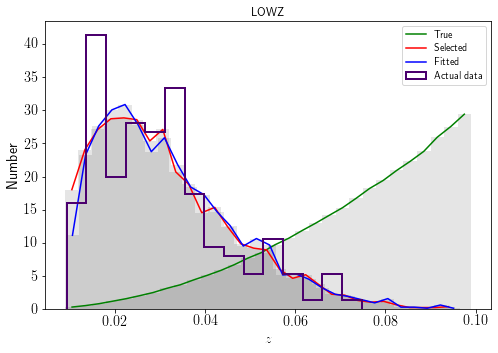

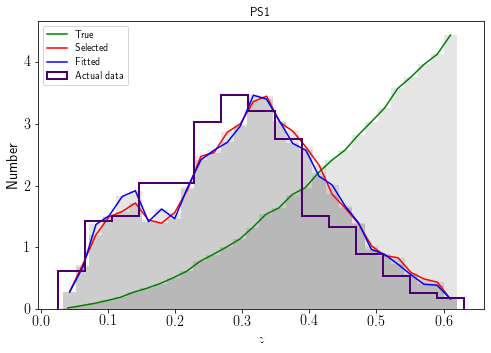

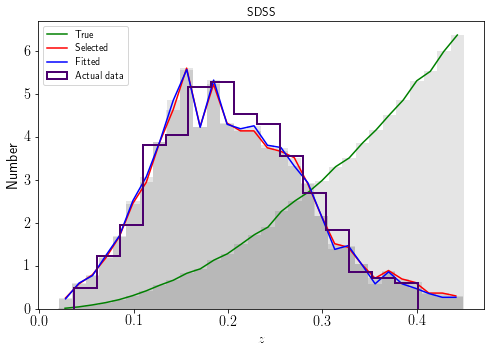

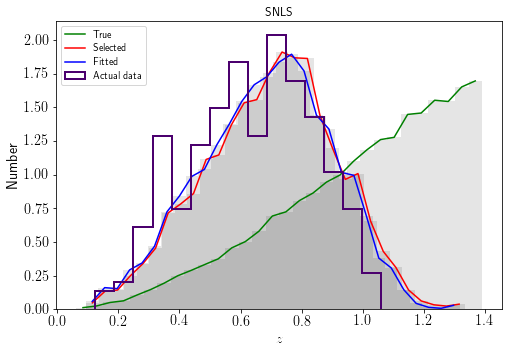

In [39]:
histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}

toplot = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}
histout = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumpsurv, dumpsass, fitsurv]
keyy = ['GENZ', 'GENZ', 'zCMB']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for s in lsurv:
    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    for tipe, df, key, c, l in zip(tipee, dff, keyy, cc, labell):
        toplot[s][tipe] = df[s][key]
        histout[s][tipe] = ax.hist(toplot[s][tipe], **histprop)
        ax.plot((histout[s][tipe][1][:-1]+histout[s][tipe][1][1:])/2,
                histout[s][tipe][0], color=c, label=l)
        
    ax.hist(df_full[df_full['survey']==s]['redshifts'],
    bins=15, density=True, lw=2,
    histtype='step', color='xkcd:royal purple',
    label='Actual data')
        
    ax.tick_params(labelsize='x-large')
        
    ax.set_xlabel(r'$z$', fontsize='x-large')
    ax.set_ylabel(r'Number', fontsize='x-large')
        
    ax.legend() 
        
    ax.set_title(s)
    
    fig.savefig(f'../../../Images/pdf/snana-hist_redshift-{s}.pdf', bbox_inches='tight')